# Individual Investors in the US stock market

## Motivation

With the rise of easy app-based trading, the individual investor is reshaping the U.S. stockmarket. According to the [Wall Street Journal](https://www.wsj.com/articles/individual-investor-boom-reshapes-u-s-stock-market-11598866200?mod=itp_wsj&yptr=yahoo), during the first half of 2020, individual investor shares traded in the U.S. stock market jumped from 14.9% to 19.5%, and in 2019 the total value of stocks traded in the U.S. was about 23 trillion dollars according to the [World Bank](https://data.worldbank.org/indicator/CM.MKT.TRAD.CD?end=2019&locations=US&start=1984&view=chart). Its in the interest of any brokerage company to identify the primary demographics of people who are most likely to invest their money, so they can identify likely customers and gain a larger share of this fast-growing segment of the financial market. 

## Methodology

Here we use demographic data of financial investors to build both a logistic regression and KNearestNeighbors model to understand and identify investors and non-investors. This model is then used to predict the likelihood of investment for a number of test cases. Regression is also used to identify the most important demographic characteristics in identifying potential investors.    

## Impact

Given the portion of investors vs. non-investors found in our representative data set, if we try to blindly identify potential investors we have about a 65% possibility of success. Using the model built here, using a few demographic characteristics, we are able to correctly identify someone as an investor or a non-investor with an 83% accuracy rate. 

# Introduction of the data set

The data set comes from a survey done by the RAND American Life Panel, which conducts nationally representative probability-based surveys and provides many of the data sets free of charge to the public:

https://alpdata.rand.org/index.php?page=data&p=showsurvey&syid=465

The survey was done in the field from 2016-12-14 until 2016-12-27 and was comissioned by James J. Choi (Yale University) and Adriana Z. Robertson (University of Toronto) and was published in 2020 in their paper titled "What Matters to Individual Investors? Evidence from the Horse’s Mouth" in the Journal of Finance. The full text of the paper can be found here: 

https://spinup-000d1a-wp-offload-media.s3.amazonaws.com/faculty/wp-content/uploads/sites/27/2019/09/Horses-mouth-2019.09.29.pdf

The survey asked 1,013 U.S. individuals how well leading academic theories describe their perspective on their finances. Here in this project, we disregard most of the main survey questions and instead focus on the demographic information, in order to see if we can build a model that can predict the kind of people who invest their money in the stock market and those who do not based only on demographic characteristics.

# Description of variables and exploratory data analysis

We first import the necessary libraries, import the data, and examine it in its raw form.

In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats 

%matplotlib inline

In [2]:
df_raw = pd.io.stata.read_stata('investors.dta')
df_raw.head()

,prim_key,tsstart,tsend,consent,gender,calcage,birthyear,currentlivingsituation,borninus,stateborn,...,iii_b_4,iii_b_5,iii_b_6,iv_a,iv_a_1,iv_a_2,iv_b_1,iv_b_2,cs_001,weight
0,10027497:1,2016-12-14 17:26:57,2016-12-14 17:55:21,1.0,2,57,59,1,1,32.0,...,2.0,4.0,4.0,2.0,3.0,3.0,1.0,4.0,2.0,0.298804
1,10027500:1,2016-12-14 21:10:31,2016-12-14 21:28:09,1.0,1,54,62,3,1,48.0,...,3.0,3.0,4.0,4.0,1.0,3.0,2.0,2.0,2.0,1.952258
2,10027504:1,2016-12-19 15:38:03,2016-12-19 15:45:32,1.0,1,37,79,1,1,8.0,...,NaN,3.0,3.0,1.0,4.0,4.0,4.0,4.0,3.0,1.931925
3,10027513:1,2016-12-16 21:33:52,2016-12-16 21:51:25,1.0,1,66,49,1,1,21.0,...,2.0,4.0,3.0,2.0,2.0,3.0,1.0,1.0,1.0,0.316861
4,10027517:1,2016-12-20 12:50:28,2016-12-20 13:17:27,1.0,1,55,61,1,1,30.0,...,NaN,2.0,4.0,4.0,3.0,1.0,3.0,3.0,2.0,0.359180


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1255 entries, 0 to 1254
Columns: 123 entries, prim_key to weight
dtypes: float32(1), float64(106), int8(12), object(4)
memory usage: 1.1+ MB


There are a large number of columns, where the meaning of the labels can be found in the file *'labels_clean.xlsx'* and all questions can be found at the ALP website:
https://alpdata.rand.org/index.php?page=data&p=showsurvey&syid=465 

Since we are only interested in demographic information, or characteristics of the survey participant (and not their perspective on finance) we can manually select the relevant demographic columns. These are the following:

- **gender** ('What is your gender'): 1 - Male, 2 - Female

- **calcage** ('What is your age'): Integer

- **currentlivingsituation** ('Could you tell us what your current living situation is?'): 1 - Married or living with a partner, 2 - Separated, 3 - Divorced, 4 - Widowed, 5 - Never married

- **borninus** (Were you born in the United States?): 1 - Yes, 2 - No

- **familyincome** ('Which category represents the total combined income of all members of your family (living here) during the past 12 months? This includes money from jobs, net income from business, farm or rent, pensions, dividends, interest, social security payments and any other money income received by members of your family who are 15 years of age or older.'): 1 - Less than \\$5,000, 2 - \\$5,000 to \\$7,499, 3 - \\$7,500 to \\$9,999, 4 - \\$10,000 to \\$12,499, 5 - \\$12,500 to \\$14,999, 6 - \\$15,000 to \\$19,999, 7 - \\$20,000 to \\$24,999, 8 - \\$25,000 to \\$29,999, 9 - \\$30,000 to \\$34,999, 10 - \\$35,000 to \\$39,999, 11 - \\$40,000 to \\$49,999, 12 - \\$50,000 to \\$59,999, 13 - \\$60,000 to \\$74,999, 14 - \\$75,000 or more

- **highesteducation** ('What is the highest level of school you have completed or the highest degree you have received?): 1 - Less than 1st grade, 2 - 1st, 2nd , 3rd, or 4th grade, 3 5th or 6th grade, 4 - 7th or 8th grade, 5 - 9th grade, 6 - 10th grade, 7 - 11th grade, 8 - 12th grade NO DIPLOMA, 9 - HIGH SCHOOL GRADUATE high school DIPLOMA or the equivalent (For example: GED), 10 - Some college but no degree, 11 - Associate degree in college Occupational/vocational program, 12 - Associate degree in college Academic program, 13 - Bachelor's degree (For example: BA,AB,BS), 14 - Master's degree (For example: MA,MS,MEng,MEd,MSW,MBA), 15 - Professional School Degree (For example: MD,DDS,DVM,LLB,JD), 16 - Doctorate degree (For example: PhD,EdD)

- **doyouwork** ('Do you work for someone else, are you self-employed, or what?'): 1 - Work for someone else, 2 - Self-employed, 3 - Other

- **ethnicity** ('Do you consider yourself primarily white or Caucasian, Black or African American, American Indian, or Asian?'): 1 - White/Caucasian, 2 - Black/African American, 3 - American Indian or Alaskan Native, 4 - Asian or Pacific Islander, 5 - Other

Note: some redundant variables are ignored. For instance **currentjobstatus** gives the same information as **doyouwork**.

***

We also extract the dependent variable we are interested in: 

- **pct_today** ("What percentage of your investable financial assets is currently invested in stocks, either directly or through mutual funds?"): Real number

The answers are given in percentage values, but since we are primarily interested in the question of whether someone decides to participate in the stock market or not, we will change this variable to a binary value: '0' for 'does not participate and '1' for 'participates

***

There is also a variable we would like to filter by:

- **consent** (Please indicate whether you would like to participate in this study.): 1 - Yes, I would like to participate in this study, 2 - No, I would not like to participate in this study.
    - We make sure all the participants we are looking at have consented to the study. I don't actually know why there are answers from non-consenting participants, but perhaps this helps to filter out people who did not read the instructions very well. 


In [4]:
# For some reason there are 86 people who did not consent to the survey, but still filled out the survey.
df_raw.consent.value_counts()

1.0    1202
2.0      33
Name: consent, dtype: int64

In [5]:
# Let's look at only consenting participants.
df_raw = df_raw[df_raw.consent == 1.0]
df_raw.consent.value_counts()

1.0    1202
Name: consent, dtype: int64

In [6]:
#Filter to only relevant variables
df=df_raw.loc[:,['gender','calcage','currentlivingsituation','borninus',
                 'familyincome', 'highesteducation','doyouwork','ethnicity','pct_today']]
df.head()

,gender,calcage,currentlivingsituation,borninus,familyincome,highesteducation,doyouwork,ethnicity,pct_today
0,2,57,1,1,14.0,13,1.0,1.0,50.0
1,1,54,3,1,11.0,9,1.0,1.0,5.0
2,1,37,1,1,13.0,10,1.0,1.0,10.0
3,1,66,1,1,14.0,13,1.0,1.0,60.0
4,1,55,1,1,14.0,10,1.0,1.0,85.0


In [7]:
# Let's first look at the dependent variable, pct_today. There are a number of pct_values that are greater than 100. 
df[df.pct_today > 100].pct_today.value_counts()

99109992.0    1
5000.0        1
35000.0       1
2000000.0     1
Name: pct_today, dtype: int64

In [8]:
# Since there is no explanation for how someone can invest more than 100 percent of their finances, we filter these out. 
df = df[df.pct_today <= 100]

In [9]:
# Here we relabel pct_today to be a binary variabel
df.loc[df.pct_today > 0,'pct_today'] = 1
df.pct_today.value_counts()

1.0    708
0.0    377
Name: pct_today, dtype: int64

In [10]:
### Let's also check how many null values there are in each column

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  1085 non-null   int8   
 1   calcage                 1085 non-null   int8   
 2   currentlivingsituation  1085 non-null   int8   
 3   borninus                1085 non-null   int8   
 4   familyincome            1081 non-null   float64
 5   highesteducation        1085 non-null   int8   
 6   doyouwork               770 non-null    float64
 7   ethnicity               1084 non-null   float64
 8   pct_today               1085 non-null   float32
dtypes: float32(1), float64(3), int8(5)
memory usage: 43.4 KB


There are quite a few **null** values and **pct_today** values. We will deal with those when we do feature engineering. 

 ## Plotting the dependencies of the variables. 

First we examine the variables where the numerical value has some meaning and plot pairwise plots with the color scheme dictated by **pct_today**

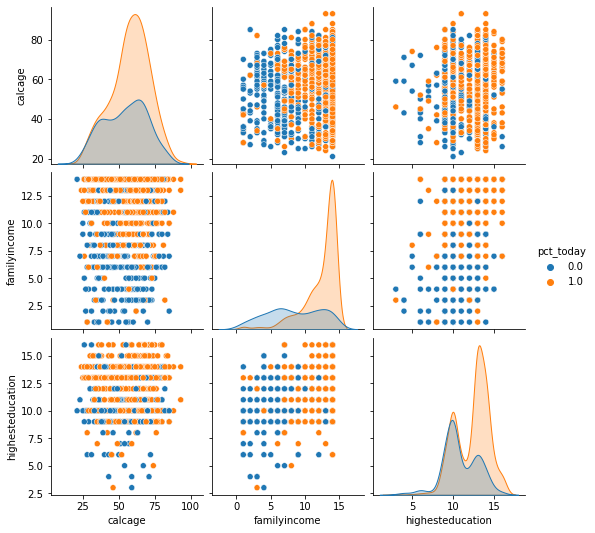

In [12]:
columns = ['calcage','familyincome','highesteducation']

sns.pairplot(df,x_vars = columns, y_vars = columns, hue = 'pct_today')

It definitely looks like **familyincome** and **highesteducation** really affect the percentage of people who invest, with some effect from **calcage**. There does look like there is a distinction between pct_today in a few of the pairwise plots. 

Let's now examine the categorical variables using bar charts. 

Text(0.5, 0.98, 'All categorical variables')

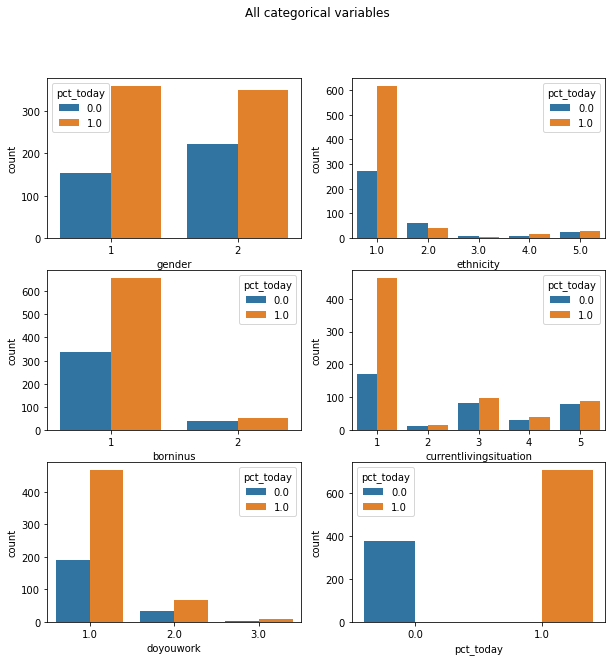

In [13]:
fig, ax =plt.subplots(3,2, figsize =(10,10))
sns.countplot(x = df['gender'], hue = df['pct_today'], ax=ax[0,0])
sns.countplot(x = df['ethnicity'], hue = df['pct_today'], ax=ax[0,1])
sns.countplot(x = df['borninus'], hue = df['pct_today'], ax=ax[1,0])
sns.countplot(x = df['currentlivingsituation'], hue = df['pct_today'], ax=ax[1,1])
sns.countplot(x = df['doyouwork'], hue = df['pct_today'], ax=ax[2,0])
sns.countplot(x = df['pct_today'], hue = df['pct_today'], ax=ax[2,1])

fig.suptitle('All categorical variables') 

It seems like there is some effect from gender, borninus, ethnicity, and currentliving situation but these variables will need to be investigated quantitatively and possibly after downsampling. We will return to these later. There is an imbalance of data, with too many 'does invest' outcomes. 

However, we can see that many of the categorical variables have no effect on **pct_today**, possibily because their numerical values have no meaning. Consequently, the next thing we need to do is some feature engineering. 

# Feature Engineering

First we do a little feature engineering that will be applied no matter the algorithm, and which will not pollute the test set for Cross Validation. This will be to change binary variables to have '0' and '1' values, and to hot-encode categorical variables with more than 2 categories.  

In [14]:
# Change the binary variable, 'gender' to have '0' or '1' values
df.loc[df.gender == 2, 'gender'] = 0
df.gender.value_counts()

0    572
1    513
Name: gender, dtype: int64

In [15]:
# Change the binary variable, 'borninus' to have '0' or '1' values
df.loc[df.borninus == 2, 'borninus'] = 0
df.borninus.value_counts()

1    994
0     91
Name: borninus, dtype: int64

In [16]:
# Check out currentlivingsituation (1 - Married or living with a partner, 2 - Separated, 3 - Divorced, 4 - Widowed, 5 - Never married)
df.currentlivingsituation.value_counts()
# We will only take first 3 columns for statistical analysis otherwise StatModels will not be able to converge. Same with the following variables.

1    635
3    182
5    167
4     72
2     29
Name: currentlivingsituation, dtype: int64

In [17]:
# Hot encode current living situation 
df = pd.get_dummies(df, columns = ['currentlivingsituation'])

In [18]:
df.doyouwork.value_counts()

1.0    658
2.0    100
3.0     12
Name: doyouwork, dtype: int64

In [19]:
# Hot encode do you work (1 - Work for someone else, 2 - Self-employed, 3 - Other)
df = pd.get_dummies(df, columns = ['doyouwork'])

In [20]:
df.ethnicity.value_counts()

1.0    889
2.0    104
5.0     55
4.0     25
3.0     11
Name: ethnicity, dtype: int64

In [21]:
# Hot encode do you ethnicity (1 - White/Caucasian, 2 - Black/African American, 3 - American Indian or Alaskan Native, 4 - Asian or Pacific Islander, 5 - Other)
df = pd.get_dummies(df, columns = ['ethnicity'])

In [22]:
df.columns

Index(['gender', 'calcage', 'borninus', 'familyincome', 'highesteducation',
       'pct_today', 'currentlivingsituation_1', 'currentlivingsituation_2',
       'currentlivingsituation_3', 'currentlivingsituation_4',
       'currentlivingsituation_5', 'doyouwork_1.0', 'doyouwork_2.0',
       'doyouwork_3.0', 'ethnicity_1.0', 'ethnicity_2.0', 'ethnicity_3.0',
       'ethnicity_4.0', 'ethnicity_5.0'],
      dtype='object')

Here we drop any of the hot-encoded values that are below %10 of the full data set. These will make logistic regression difficult to converge. 

In [23]:
df_stats = df.drop(['currentlivingsituation_4',
       'currentlivingsituation_2','doyouwork_3.0','ethnicity_3.0',
       'ethnicity_4.0', 'ethnicity_5.0'],axis = 1)

df_stats.head()

,gender,calcage,borninus,familyincome,highesteducation,pct_today,currentlivingsituation_1,currentlivingsituation_3,currentlivingsituation_5,doyouwork_1.0,doyouwork_2.0,ethnicity_1.0,ethnicity_2.0
0,0,57,1,14.0,13,1.0,1,0,0,1,0,1,0
1,1,54,1,11.0,9,1.0,0,1,0,1,0,1,0
2,1,37,1,13.0,10,1.0,1,0,0,1,0,1,0
3,1,66,1,14.0,13,1.0,1,0,0,1,0,1,0
4,1,55,1,14.0,10,1.0,1,0,0,1,0,1,0


In order to do linear regression on the model in order to examine which variables to keep, we normalize the data. 

In [24]:
from sklearn import preprocessing

#norm_columns = ['familyincome','calcage','highesteducation']
#x = a[norm_columns]
#x.info()

columns = df_stats.columns

x = df_stats
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(x_scaled, columns = columns)
df_norm.head()

,gender,calcage,borninus,familyincome,highesteducation,pct_today,currentlivingsituation_1,currentlivingsituation_3,currentlivingsituation_5,doyouwork_1.0,doyouwork_2.0,ethnicity_1.0,ethnicity_2.0
0,0.0,0.500000,1.0,1.000000,0.769231,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.458333,1.0,0.769231,0.461538,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.222222,1.0,0.923077,0.538462,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.625000,1.0,1.000000,0.769231,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.472222,1.0,1.000000,0.538462,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


# Initial Model Building

We first begin with a logistic regression model, which is easily interpretable, robust to overfitting and allows us to identify the most important and least important variables for consideration. 

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

df_norm=df_norm.dropna() #drop null values. We can impute values later when we are doing this more rigorously. 

X = df_norm.loc[:, df_norm.columns != 'pct_today']
y = df_norm.loc[:,'pct_today']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy on training set: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Accuracy on test set: {:.4f}'.format(logreg.score(X_test, y_test)))

Accuracy on training set: 0.7844
Accuracy on test set: 0.7908


We can also look at the ROC curv:

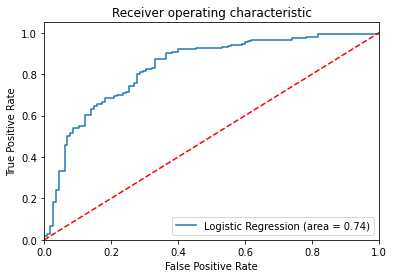

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

We also use logistic regression from StatsModels isolate the most important variables

In [27]:
import statsmodels.api as sm

model = sm.Logit(y, X)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.524718
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              pct_today   No. Observations:                 1081
Model:                          Logit   Df Residuals:                     1069
Method:                           MLE   Df Model:                           11
Date:                Tue, 25 May 2021   Pseudo R-squ.:                  0.1886
Time:                        09:26:13   Log-Likelihood:                -567.22
converged:                       True   LL-Null:                       -699.05
Covariance Type:            nonrobust   LLR p-value:                 3.830e-50
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
gender                      -0.0571      0.152     -0.376      0.707      -0.355       0.241
calcage                     -0.0470      0.417     -0.113      0.910      -0.865       0.771
borninus                    -0.4408      0.283     -1.559      0.119      -0.995       0.113
familyincome                 3.7874      0.363     10.429      0.000       3.076       4.499
highesteducation            -0.3815      0.456     -0.837      0.403      -1.275       0.512
currentlivingsituation_1    -0.9849      0.270     -3.645      0.000      -1.515      -0.455
currentlivingsituation_3    -0.8775      0.287     -3.061      0.002      -1.439      -0.316
currentlivingsituation_5    -0.8703      0.303     -2.871      0.004      -1.465      -0.276
doyouwork_1.0                0.1861      0.180      1.032      0.302      -0.167       0.539
doyouwork_2.0                0.2653      0.282      0.942      0.346      -0.286       0.817
ethnicity_1.0               -0.6067      0.288     -2.105      0.035      -1.172      -0.042
ethnicity_2.0               -1.5673      0.345     -4.539      0.000      -2.244      -0.891
============================================================================================
"""

From the coefficients we also note that, by far, **familyincome** is the most important variable. We also see from the p-values that **gender** and **calcage** do not really influence **pct_today**, so we remove them from our data set. 

In [28]:
df_norm2 = df_norm.drop(['gender','calcage'],axis = 1)

Let's try logistic regression again without these variables 

In [29]:
X = df_norm2.loc[:, df_norm2.columns != 'pct_today']
y = df_norm2.loc[:,'pct_today']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy on training set: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Accuracy on test set: {:.4f}'.format(logreg.score(X_test, y_test)))

Accuracy on training set: 0.7844
Accuracy on test set: 0.8000


Great! It got a little better. However, even a small increase in accuracy would increase our potential market by billions of dollars, so we continue to try to optimize the model. Additionally, we need to look at metrics of precision and recall. 

In [30]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print('precision: {:.4f}'.format(precision))
print('recall: {:.4f}'.format(recall))
print('accuracy: {:.4f}'.format(accuracy))

precision: 0.8008
recall: 0.9190
accuracy: 0.8000


In this context:

Recall measures how well a person will be identified as an investor if they are actually an investor.
Precision measures how well a person will be identified as a non-investor if they don't invest.

We will assume that we are trying to maximize our reach, and have large marketing budgets, so that if there is an investor we would like to reach them. Therefore we would like a model that maximizes recall. If we sacrafice a bit on precision and find a lower precision, this means we have a higher chance of targeting people who are actually not very likely to invest. 

Let's also take a look at the ROC curve:

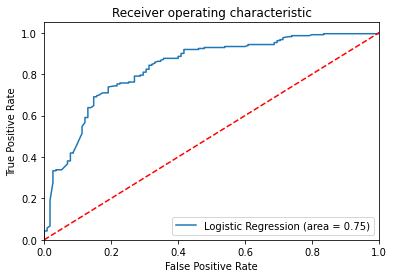

In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

It has improved slightly as well. 

Since we have a variety of different variables, it is likely that the decision boundary between investors and non-investors is not a flat hyperplane. Since K-Nearest-Neighbors is also a simple algorithm, and is additionally capable of non-linear decision boundaries, so next we use KNN as another algorithm to test the data. 

In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print('precision: {:.4f}'.format(precision))
print('recall: {:.4f}'.format(recall))
print('accuracy: {:.4f}'.format(accuracy))

precision: 0.7664
recall: 0.8905
accuracy: 0.7538


Here we find that logistic regression actually does better in all three metrics. 

However, the recall score is quite close and so a few tweaks to the parameters and features for each model might give a change to the recall.

So now we would like to systematically study how different feature engineering choices, and also how different models, perform with this data. So next we try a few other options for our model to see if we can improve the recall futher.

# Pipeline Construction

We go back to our original dataset before we did any normalization, or deleted any null values.  

Next we describe a few parameters we would like to vary in these different models. 


In [33]:
#df_stats.info()

First we import all the preprocessing modules and machine learning models we will be testing out, as well as **RandomizedSearchCV** which helps us to try out all of the parameters for each of our models. 

- For preprocessing, we allow the pipleline to choose **StandardScaler** instead of **MinMaxScaler** in case there are any outliers that we want to have reduced influence. 

- We give the pipeline the option of using **PolynomialFeatures**, which takes into account if there are any interactions between variables or nonlinear dependencies. 

- We use either **IterativeImputer** or **SimpleImputer** to fill in null values. Since there are very few at this stage in the data processing, we don't expect this variable to change things too much either way, but we include it for completeness. 

- Finally, we also search for the optimal hyperparameters for each chosen algorithm to give us maximum prediction power. 

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
#from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer  
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

Then we build our pipeline

In [42]:
# Building a Pipeline inside RandomSearchCV, responsible for finding the best model and it's parameters
# Based on a kaggle tutorial notebook (https://www.kaggle.com/pedrodematos/titanic-a-complete-approach-to-top-6-rank)

def defineBestModelPipeline(df, target, categorical_columns, numeric_columns):
    
    # Splitting original data into Train and Test BEFORE applying transformations
    # Later in RandomSearchCV, x_train will be splitted into train/val sets
    # The transformations are going to be fitted specifically on the train set,
    # and then applied to both train/test sets. This way, information leakage is avoided!
    x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.10, random_state=42)
    y_train = y_train.to_numpy() # Transforming training targets into numpy arrays
    y_test = y_test.to_numpy() # Transforming test targets into numpy arrays
    
    # Numeric Transformers
    # Here, we are creating different several different data transformation pipelines 
    # to be applied in our numeric features
    numeric_transformer_1 = Pipeline(steps=[('imp', IterativeImputer(max_iter=30, random_state=42)),
                                            ('scaler', MinMaxScaler())])
    numeric_transformer_2 = Pipeline(steps=[('imp', IterativeImputer(max_iter=20, random_state=42)),
                                            ('scaler', StandardScaler())])
    numeric_transformer_3 = Pipeline(steps=[('imp', SimpleImputer(strategy='mean')),
                                            ('scaler', MinMaxScaler())])
    numeric_transformer_4 = Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                                            ('scaler', StandardScaler())])

    #Applies transformers to columns of an array or pandas DataFrame.   
    data_transformations_1 = ColumnTransformer(transformers=[('num', numeric_transformer_1, numeric_columns)])
    data_transformations_2 = ColumnTransformer(transformers=[('num', numeric_transformer_2, numeric_columns)])
    data_transformations_3 = ColumnTransformer(transformers=[('num', numeric_transformer_3, numeric_columns)])
    data_transformations_4 = ColumnTransformer(transformers=[('num', numeric_transformer_4, numeric_columns)])    
   
    # initialize pipeline
    pipe = Pipeline(steps=[('data_transformations', data_transformations_1), # Initializing data transformation step by choosing any of the above
                           ('feature_eng', None), # Initializing feature engineering step by choosing any desired method
                           ('clf', LogisticRegression())]) # Initializing modeling step of the pipeline with any model object
                           #memory='cache_folder') -> Used to optimize memory when needed
    
    #parameter grid
    params_grid = [
                    {'data_transformations': [data_transformations_1, data_transformations_2, data_transformations_3, data_transformations_4],
                     'feature_eng': [None, 
                                     PolynomialFeatures(degree=1), PolynomialFeatures(degree=2), PolynomialFeatures(degree=3)],
                     'clf': [KNeighborsClassifier()],
                     'clf__n_neighbors': stats.randint(1, 50),
                     'clf__metric': ['minkowski', 'euclidean']},

                    {'data_transformations': [data_transformations_1, data_transformations_2, data_transformations_3, data_transformations_4],
                     'feature_eng': [None, 
                                     PolynomialFeatures(degree=1), PolynomialFeatures(degree=2), PolynomialFeatures(degree=3)],
                     'clf': [LogisticRegression()],
                     'clf__penalty': ['l1', 'l2'],
                     'clf__C': stats.uniform(0.01, 10)},
                    
            ]
        
        
    #metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    metrics = ['recall'] #We would like to optimize for best recall

    best_model_pipeline = RandomizedSearchCV(pipe, params_grid, n_iter=500, 
                                     scoring=metrics, refit='recall', 
                                     n_jobs=-1, cv=5, random_state=21)

    best_model_pipeline.fit(x_train, y_train)


    # At last, we check the final results
    print("\n\n#---------------- Best Data Pipeline found in RandomSearchCV  ----------------#\n\n", best_model_pipeline.best_estimator_[0])
    print("\n\n#---------------- Best Feature Engineering technique found in RandomSearchCV  ----------------#\n\n", best_model_pipeline.best_estimator_[1])
    print("\n\n#---------------- Best Classifier found in RandomSearchCV  ----------------#\n\n", best_model_pipeline.best_estimator_[2])
    print("\n\n#---------------- Best Estimator's average Recall Score on CV (validation set) ----------------#\n\n", best_model_pipeline.best_score_)

    return x_train, x_test, y_train, y_test, best_model_pipeline

In [43]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score


def testSetResultsClassifier(classifier, x_test, y_test):
    predictions = classifier.predict(x_test)
    
    results = []
    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    #roc_auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    
    results.append(f1)
    results.append(precision)
    results.append(recall)
    #results.append(roc_auc)
    results.append(accuracy)
    
    print("\n\n#---------------- Test set results (Best Classifier) ----------------#\n")
    #print("F1 score, Precision, Recall, ROC_AUC score, Accuracy:")
    print("F1 score, Precision, Recall, Accuracy:")
    print(results)
    
    return results

In [44]:
# Identify the numeric and categorical columns and then the dataset into X and y variables. 

X = df_stats.loc[:, df_stats.columns != 'pct_today']
y = df_stats.loc[:,'pct_today']
#df_stats.columns

numeric_columns = ['calcage','familyincome', 'highesteducation']
categorical_columns = ['gender', 'borninus',
       'currentlivingsituation_1',
       'currentlivingsituation_3',
       'currentlivingsituation_5', 'doyouwork_1.0', 'doyouwork_2.0',
       'doyouwork_3.0', 'ethnicity_1.0', 'ethnicity_2.0']

In [45]:
# Calling the function above, returning train/test data and best model's pipeline
x_train, x_test, y_train, y_test, best_model_pipeline = defineBestModelPipeline(df, y, categorical_columns, numeric_columns)

# Checking best model's performance on test data
test_set_results = testSetResultsClassifier(best_model_pipeline, x_test, y_test)




#---------------- Best Data Pipeline found in RandomSearchCV  ----------------#

 ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imp',
                                                  IterativeImputer(max_iter=20,
                                                                   random_state=42)),
                                                 ('scaler', StandardScaler())]),
                                 ['calcage', 'familyincome',
                                  'highesteducation'])])


#---------------- Best Feature Engineering technique found in RandomSearchCV  ----------------#

 PolynomialFeatures(degree=3)


#---------------- Best Classifier found in RandomSearchCV  ----------------#

 KNeighborsClassifier(metric='euclidean', n_neighbors=39)


#---------------- Best Estimator's average Recall Score on CV (validation set) ----------------#

 0.9438226744186047


#---------------- Test set results (Best Classifier) ------------

## Results

We find that the best classifier to use is actually the KNeighborsClassifier, using polynomial features (degree = 3), which gives us an improved 0.97 recall score. We can say that 97% of the time we will be able to predict that someone is an investor if they are indeed an investor, given only demographic information. The fact that the best feature engineering technique used includes polynomial features indicates that there are interactions between features and non-linear features which are important to the model. This makes our model more opaque, but given the large increase in our established metric of importance (recall), we believe that this model should be used for prediction. Given the portion of investors vs. non-investors found in our representative data set, if we try to blindly identify potential investors we have about a 65% possibility of success. Using the model built here, using a few demographic characteristics, we are able to correctly identify someone as an investor or a non-investor with an 83% accuracy rate. 